## Predictive Modeling
# A. Pass/Fail Classification Model
The goal here is to predict whether a student will pass or fail based on available features like attendance, health status, parental engagement, and previous term scores.

# Step 1: Data Preparation for Pass/Fail Model
1. Convert the target variable into a binary classification problem (Pass = 1, Fail = 0).
2. Select relevant features (e.g., health status, parental engagement, academic scores, attendance, etc.)
3. Train and test the model using Isolation forest with Anomaly detection algorithm "Isolation forest  as a baseline model.

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the academic data and student bio-data
students_df = pd.read_csv("../DataGeneration/students_bio_data.csv")
academic_df = pd.read_csv("../DataGeneration/academic_history_data.csv")
parents_df = pd.read_csv("../DataGeneration/parents_bio_data.csv")
teacher_df = pd.read_csv("../DataGeneration/Teachers_bio_data.csv")

##  Step 2: Create the pass/fail classification target variable

In [72]:
# Assuming a student passes if Total Score >= 50% for their average across terms
academic_df['Pass/Fail'] = np.where(academic_df['Total Score'] >= 50, 1, 0)

In [73]:
data = pd.merge(academic_df, students_df[['Student ID', 'Health Status', 'Disorder', 'Living Arrangement', 'Extracurricular Activities', 'Stream', 'Grade Level','LGA of residence','First Name',	'Last Name',	"Gender",	"Age",'State of Origin']], on='Student ID')

In [74]:
data.columns = data.columns.str.strip()
parents_df.columns = parents_df.columns.str.strip()


In [75]:
# Convert both to string, assuming `Student ID` should be a string identifier
data['Student ID'] = data['Student ID'].astype(str)
parents_df['Student ID'] = parents_df['Student ID'].astype(str)


In [76]:
# Merge dataframes using the cleaned and consistent column names
data = pd.merge(data, 
                parents_df[["Student ID", "Occupation", "Financial Status", "Education Level", "Engagement in School Activities"]], 
                on='Student ID', 
                how='left')  


In [77]:
# Correcting the dataframe reference
data = pd.merge(data, 
               teacher_df[['Teacher ID', 'Years of Experience', 'Qualification', 'Residence Type', 'LGA of residence', 'Digital Literacy', 'Salary ₦', 'Teaching Level', 'Subject Specialization']], 
                on='Teacher ID', 
                how='left')



In [78]:
data.head()

,Student ID,Grade Level_x,Subject,Term,Teacher ID,Test Score,Exam Score,Total Score,Attendance,Cumulative Score,...,Education Level,Engagement in School Activities,Years of Experience,Qualification,Residence Type,LGA of residence_y,Digital Literacy,Salary ₦,Teaching Level,Subject Specialization
0,STU001,JSS1,English Studies,First Term,TCH018,28,31,59,70,64.00,...,Secondary,Medium,12,NCE,Lives in School,Lagos Island,Low,174987,Junior,Business Studies
1,STU001,JSS1,English Studies,Second Term,TCH018,17,36,53,77,64.00,...,Secondary,Medium,12,NCE,Lives in School,Lagos Island,Low,174987,Junior,Business Studies
2,STU001,JSS1,English Studies,Third Term,TCH018,31,49,80,70,64.00,...,Secondary,Medium,12,NCE,Lives in School,Lagos Island,Low,174987,Junior,Business Studies
3,STU001,JSS1,Literature in English,First Term,TCH015,32,36,68,92,73.33,...,Secondary,Medium,7,NCE,Lives in School,Ojo,Low,226518,Senior,French
4,STU001,JSS1,Literature in English,Second Term,TCH015,35,52,87,87,73.33,...,Secondary,Medium,7,NCE,Lives in School,Ojo,Low,226518,Senior,French


In [79]:
data.isna().sum()

Student ID                             0
Grade Level_x                          0
Subject                                0
Term                                   0
Teacher ID                             0
Test Score                             0
Exam Score                             0
Total Score                            0
Attendance                             0
Cumulative Score                       0
Average Attendance                     0
JAMB Score                         81969
Passed Core Subjects               81969
Cumulative Attendance Rate             0
Pass/Fail                              0
Health Status                          0
Disorder                               0
Living Arrangement                     0
Extracurricular Activities             0
Stream                                 0
Grade Level_y                          0
LGA of residence_x                     0
First Name                             0
Last Name                              0
Gender          

In [80]:
data.dtypes

Student ID                          object
Grade Level_x                       object
Subject                             object
Term                                object
Teacher ID                          object
Test Score                           int64
Exam Score                           int64
Total Score                          int64
Attendance                           int64
Cumulative Score                   float64
Average Attendance                 float64
JAMB Score                         float64
Passed Core Subjects                object
Cumulative Attendance Rate         float64
Pass/Fail                            int32
Health Status                       object
Disorder                            object
Living Arrangement                  object
Extracurricular Activities          object
Stream                              object
Grade Level_y                       object
LGA of residence_x                  object
First Name                          object
Last Name  

In [81]:
# Import necessary libraries for preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Separate features and target
X = data.drop(['Pass/Fail', 'Total Score', 'Teacher ID','Student ID', 'First Name', 'Last Name', 'Term', 'Grade Level_x', 'Grade Level_y'], axis=1)
y = data['Pass/Fail']

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define pipelines for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply transformations
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)






In [82]:
print(f" x train {X_train.shape}")
print(f" x test {X_test.shape}")
print(f" y_train{y_train.shape}")
print(f" y_train{y_test.shape}")

 x train (58938, 204)
 x test (25260, 204)
 y_train(58938,)
 y_train(25260,)


# 2. Baseline Model (Isolation Forest for Anomaly Detection)

In [83]:
# Convert to a dense format if data size is manageable
X_train_dense = X_train.toarray()

# Fit Isolation Forest model for anomaly detection using dense matrix
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outliers = isolation_forest.fit_predict(X_train_dense)

# Filter out anomalies for model training
X_train_clean = X_train_dense[outliers == 1]
y_train_clean = y_train[outliers == 1]


In [84]:
print(f" x train{X_train_clean.shape}")
print(f" y_train{y_train_clean.shape}")


 x train(58348, 204)
 y_train(58348,)


# 3. Feature Selection Using StratifiedKFold and Recursive Feature Elimination

In [85]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Define logistic regression model for feature selection
log_reg = LogisticRegression(random_state=42)
rfe_selector = RFE(estimator=log_reg, n_features_to_select=7, step=1)
rfe_selector.fit(X_train_clean, y_train_clean)

# Step 7: Extract feature names after transformation
categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
numeric_feature_names = numeric_features

# Combine the numeric and categorical feature names
all_feature_names = np.hstack([numeric_feature_names, categorical_feature_names])


# Get the selected features
selected_features = [feature for feature, selected in zip(X.columns, rfe_selector.support_) if selected]
print(f"Top 7 Selected Features: {selected_features}")

# Transform the dataset to keep only selected features
X_train_selected = rfe_selector.transform(X_train_clean)
X_test_selected = rfe_selector.transform(X_test)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Top 7 Selected Features: ['Subject', 'Test Score']


In [86]:
print(f"Top 7 Selected Features: {selected_features}")
print(f"Shape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test_selected: {X_test_selected.shape}")

Top 7 Selected Features: ['Subject', 'Test Score']
Shape of X_train_selected: (58348, 7)
Shape of X_test_selected: (25260, 7)


# 4. Logistic Regression Model

In [87]:
# Train a Logistic Regression model
log_reg_baseline = LogisticRegression(random_state=42)
log_reg_baseline.fit(X_train_selected, y_train_clean)

# Make predictions on test set
y_pred_logreg = log_reg_baseline.predict(X_test_selected)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
classification_report_result = classification_report(y_test, y_pred_logreg)
confusion_mat = confusion_matrix(y_test, y_pred_logreg)

print(f'Accuracy: {accuracy:.2f}')
print(f'Classification Report:\n{classification_report_result}')
print(f'Confusion Matrix:\n{confusion_mat}')


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00     24742

    accuracy                           1.00     25260
   macro avg       1.00      1.00      1.00     25260
weighted avg       1.00      1.00      1.00     25260

Confusion Matrix:
[[  518     0]
 [    0 24742]]


# 5. XGBoost Model with Hyperparameter Tuning (Optuna)

In [88]:
import optuna
from xgboost import XGBClassifier

# Define objective function for Optuna
def objective(trial):
    param = {
        'verbosity': 0,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    # Define XGBoost classifier
    xgb_model = XGBClassifier(**param, random_state=42)
    scores = cross_val_score(xgb_model, X_train_selected, y_train_clean, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    
    # Return mean accuracy score
    return scores.mean()

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train final XGBoost model with best parameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

xgb_final = XGBClassifier(**best_params, random_state=42)
xgb_final.fit(X_train_selected, y_train_clean)
y_pred_xgb = xgb_final.predict(X_test_selected)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)

print(f"XGBoost Model Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost Classification Report:\n{classification_report_xgb}")


[I 2024-10-07 10:09:40,961] A new study created in memory with name: no-name-e7355e4e-6595-4f24-ba8b-7f83125c0788
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-10-07 10:09:56,776] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.01272696018151479, 'max_depth': 4, 'n_estimators': 437, 'subsample': 0.5847928999265531, 'colsample_bytree': 0.6900114735073091}. Best is trial 0 with value: 1.0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

Best Hyperparameters: {'learning_rate': 0.01272696018151479, 'max_depth': 4, 'n_estimators': 437, 'subsample': 0.5847928999265531, 'colsample_bytree': 0.6900114735073091}
XGBoost Model Accuracy: 1.00
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00     24742

    accuracy                           1.00     25260
   macro avg       1.00      1.00      1.00     25260
weighted avg       1.00      1.00      1.00     25260



# 6. Feature Importance for Both Models

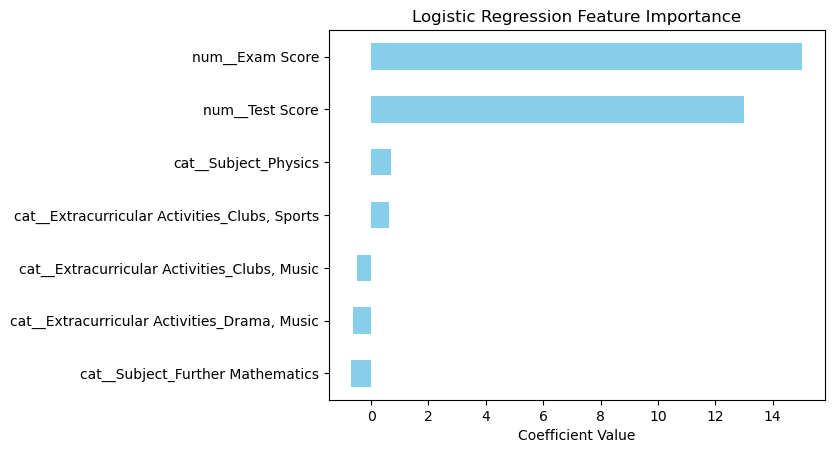

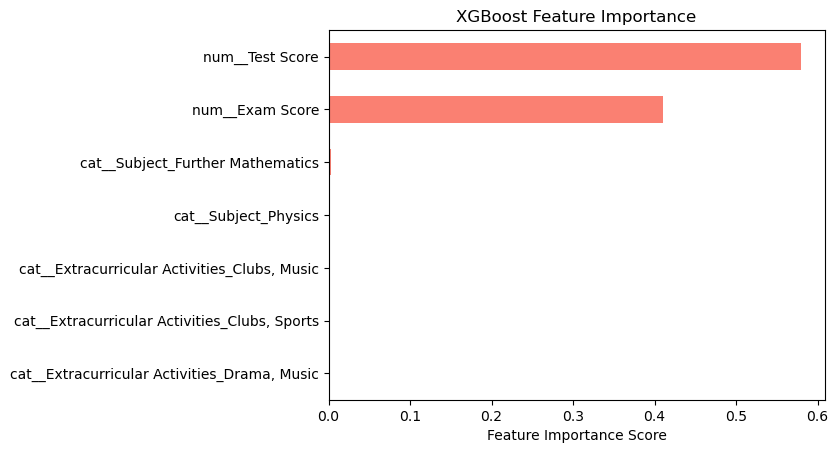

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the correct number of feature names after transformation (column names of the transformed data)
feature_names_after_transform = preprocessor.get_feature_names_out()

# Map the selected feature indices back to their original names
selected_feature_indices = rfe_selector.get_support(indices=True)
selected_feature_names = feature_names_after_transform[selected_feature_indices]

# Logistic Regression feature importance (Coefficients)
log_reg_importance = pd.Series(log_reg_baseline.coef_[0], index=selected_feature_names)
log_reg_importance.sort_values().plot(kind='barh', color='skyblue')
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Coefficient Value')
plt.show()

# XGBoost feature importance
xgb_importance = pd.Series(xgb_final.feature_importances_, index=selected_feature_names)
xgb_importance.sort_values().plot(kind='barh', color='salmon')
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance Score')
plt.show()
